# MP0 : Image Demosaicing

Welcome to CS 543! This assignment is a warm-up assignment to get you back up working from the winter break! We will try to provide you an iPython Notebook (like this) for all the future assignments! The notebook will provide you some further instructions(implementation related mainly), in addition to the ones provided on class webpage.

### Import statements

The following cell is only for import statements. You can use any of the 3 : cv2, matplotlib or skimage for image i/o and other functions. We will provide you the names of the relevant functions for each module. __{For convenience provided at the end of the class assignment webpage}__

In [60]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage
import skimage.io
import skimage.util
import skimage.exposure
import scipy
import scipy.signal
import scipy.ndimage
from pathlib import Path
%matplotlib inline

### Reading the Mosaic Image

In [61]:
IMG_DIR = 'images'
IMG_NAME = 'crayons.bmp'

In [62]:
def read_image(IMG_NAME):
    # build path relative to current notebook
    img_path = Path() / IMG_DIR / IMG_NAME
    return skimage.io.imread(img_path)

In [63]:
def write_image(img_name, im=None, ignore=False):
    if ignore:
        # don't save the image
        return
    img_path = Path() / 'report' / 'images' / img_name
    if im is None:
        plt.savefig(img_path, bbox_inches='tight')
    else:
        skimage.io.imsave(img_path, im)

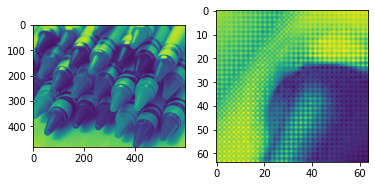

In [64]:
mosaic_img = read_image(IMG_NAME)

plt.subplot(1, 2, 1)
plt.imshow(mosaic_img);

# original view is interpolated, provides close up view to confirm this is mosaicked
plt.subplot(1, 2, 2)
plt.imshow(mosaic_img[:64, :64]);

### Linear Interpolation

In [65]:
def conv2(image, filter):
    '''Helper function to do zero-padded 2D convolution.'''
    return scipy.signal.convolve2d(
        image, filter, mode='same', boundary='fill', fillvalue=0
    )

In [66]:
def split_mosaic_image(mosaic_image):
    '''Split mosaic to different color channgels. Need this in my bonus.'''
    split_image = np.zeros(mosaic_image.shape + (3, ), dtype=mosaic_image.dtype)

    # split colors into their own layer
    #        R   G_1
    #       G_2   B
    # R
    split_image[::2, ::2, 0] = mosaic_image[::2, ::2]
    # G1/2
    split_image[::2, 1::2, 1] = mosaic_image[::2, 1::2]
    split_image[1::2, ::2, 1] = mosaic_image[1::2, ::2]
    # B
    split_image[1::2, 1::2, 2] = mosaic_image[1::2, 1::2]

    return split_image

In [67]:
def get_solution_image(mosaic_image):
    '''
    This function should return the soln image.
    Feel free to write helper functions in the above cells
    as well as change the parameters of this function.
    '''
    soln_image = split_mosaic_image(mosaic_image)

    # RB share the same kernel
    rb_kernel = [
        [0.25, 0.5,  0.25],
        [ 0.5,   1,   0.5],
        [0.25, 0.5,  0.25]
    ]
    # G does not need diagonal components
    g_kernel = [
        [   0, 0.25,    0],
        [0.25,    1, 0.25], 
        [   0, 0.25,    0]
    ]
    
    # loop over each color and filter by its kernel
    for i, kernel in enumerate((rb_kernel, g_kernel, rb_kernel)):
        soln_image[..., i] = conv2(soln_image[..., i], kernel).astype(np.uint8)

    return soln_image

In [104]:
def compute_errors(soln_image, original_image, show_err=True, return_map=False):
    '''
    Compute the Average and Maximum per-pixel error
    for the image.
    
    Also generate the map of pixel differences
    to visualize where the mistakes are made
    '''
    # use float to computer error
    soln_image = soln_image.astype(float)
    original_image = original_image.astype(float)
    err = (soln_image - original_image) ** 2

    # normalized error map for saving and display
    err_ubyte = (err - np.min(err)) / (np.max(err) - np.min(err))
    # CLAHE for each channel
    for c in range(3):
        err_ubyte[..., c] = skimage.exposure.equalize_adapthist(
            err_ubyte[..., c], clip_limit=0.5
        )
    err_ubyte = (err_ubyte * 255).astype(np.uint8)

    # preview error map
    if show_err:    
        plt.imshow(err_ubyte);

    if return_map:
        return err_ubyte 
    else:
        return np.mean(err), np.max(err)

We provide you with 3 images to test if your solution works. Once it works, you should generate the solution for test image provided to you.

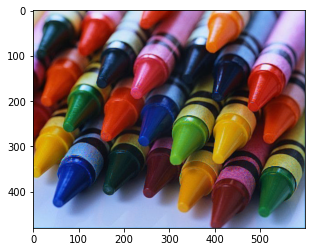

In [105]:
mosaic_image = read_image('crayons.bmp')
soln_image = get_solution_image(mosaic_image)
original_image = read_image('crayons.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('crayons-recon-linear.png', soln_image)

The average per-pixel error for crayons is: 70.91767939814815
The maximum per-pixel error for crayons is: 37636.0


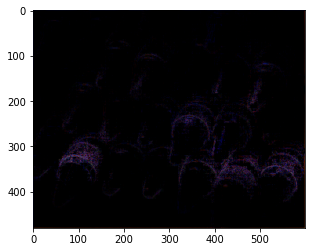

In [106]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for crayons is: "+str(pp_err))
print("The maximum per-pixel error for crayons is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('crayons-error-linear.png', err)

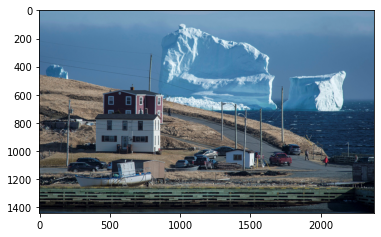

In [107]:
mosaic_image = read_image('iceberg.bmp')
soln_image = get_solution_image(mosaic_image)
original_image = read_image('iceberg.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('iceberg-recon-linear.png', soln_image)

The average per-pixel error for iceberg is: 38.32407446279193
The maximum per-pixel error for iceberg is: 23409.0


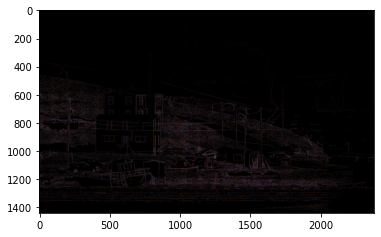

In [108]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for iceberg is: "+str(pp_err))
print("The maximum per-pixel error for iceberg is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('iceberg-error-linear.png', err)

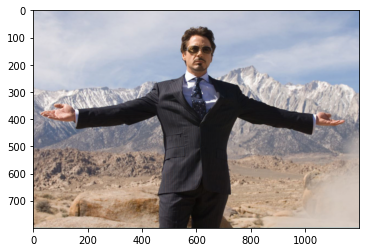

In [109]:
mosaic_image = read_image('tony.bmp')
soln_image = get_solution_image(mosaic_image)
original_image = read_image('tony.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('tony-recon-linear.png', soln_image)

The average per-pixel error for tony is: 19.402863541666665
The maximum per-pixel error for tony is: 26569.0


/home/andy/.conda/envs/ece549-mp/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: report/images/tony-error-linear.png is a low contrast image
  if __name__ == '__main__':


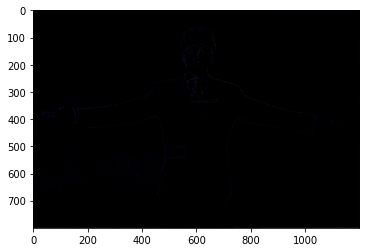

In [110]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for tony is: "+str(pp_err))
print("The maximum per-pixel error for tony is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('tony-error-linear.png', err)

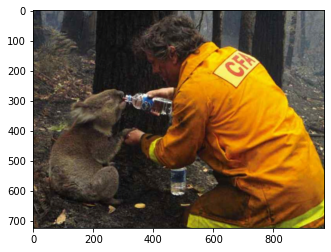

In [111]:
mosaic_image = read_image('hope.bmp')
soln_image = get_solution_image(mosaic_image)

# Generate your solution image here and show it 
plt.imshow(soln_image);

write_image('hope-recon-linear.png', soln_image)

### Freeman's Method

For details of the freeman's method refer to the class assignment webpage.

__MAKE SURE YOU FINISH LINEAR INTERPOLATION BEFORE STARTING THIS PART!!!__

In [76]:
def get_freeman_solution_image(mosaic_image, kernel_size=3):
    '''
    This function should return the freeman soln image.
    Feel free to write helper functions in the above cells
    as well as change the parameters of this function.
    
    HINT : Use the above get_solution_image function.
    '''
    # bilinear interpolation
    freeman_soln_image = get_solution_image(mosaic_image)

    # turn them to signed integer for now
    freeman_soln_image = freeman_soln_image.astype(int)

    # process R/B
    #   1. subtract G
    #   2. median filter
    #   3. add back G
    for c in (0, 2):
        tmp_image = freeman_soln_image[..., c] - freeman_soln_image[..., 1]
        tmp_image = scipy.ndimage.median_filter(tmp_image, kernel_size)
        freeman_soln_image[..., c] = tmp_image + freeman_soln_image[..., 1]
    
    # we know we are working with uint8 and need to save it this way later
    freeman_soln_image = np.clip(freeman_soln_image, 0, 255)
    freeman_soln_image = freeman_soln_image.astype(np.uint8)
    
    return freeman_soln_image

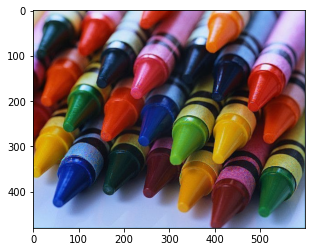

In [112]:
mosaic_image = read_image('crayons.bmp')
soln_image = get_freeman_solution_image(mosaic_image, kernel_size=3)
original_image = read_image('crayons.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('crayons-recon-freeman.png', soln_image)

The average per-pixel error for crayons is: 53.04713310185185
The maximum per-pixel error for crayons is: 28900.0


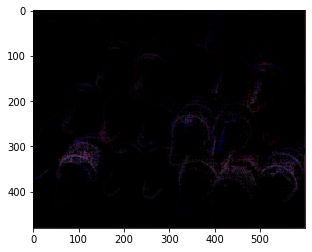

In [113]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for crayons is: "+str(pp_err))
print("The maximum per-pixel error for crayons is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('crayons-error-freeman.png', err)

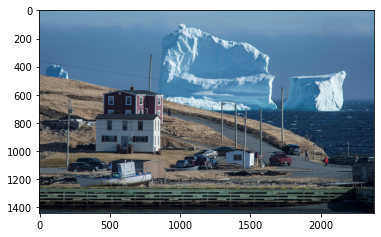

In [114]:
mosaic_image = read_image('iceberg.bmp')
soln_image = get_freeman_solution_image(mosaic_image, kernel_size=3)
original_image = read_image('iceberg.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('iceberg-recon-freeman.png', soln_image)

The average per-pixel error for iceberg is: 25.19742280063439
The maximum per-pixel error for iceberg is: 23409.0


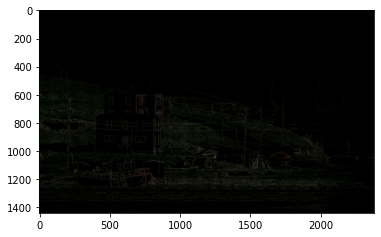

In [115]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for iceberg is: "+str(pp_err))
print("The maximum per-pixel error for iceberg is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('iceberg-error-freeman.png', err)

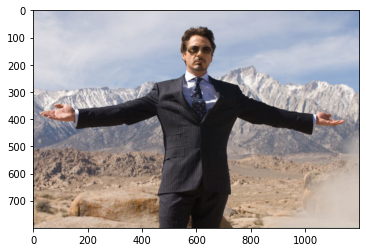

In [116]:
mosaic_image = read_image('tony.bmp')
soln_image = get_freeman_solution_image(mosaic_image, kernel_size=3)
original_image = read_image('tony.jpg')

# For sanity check display your solution image here
plt.imshow(soln_image);

write_image('tony-recon-freeman.png', soln_image)

The average per-pixel error for tony is: 14.301951041666667
The maximum per-pixel error for tony is: 26569.0


/home/andy/.conda/envs/ece549-mp/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: report/images/tony-error-freeman.png is a low contrast image
  if __name__ == '__main__':


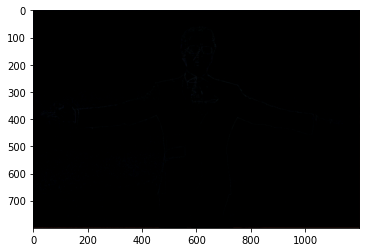

In [117]:
pp_err, max_err = compute_errors(soln_image, original_image)
print("The average per-pixel error for tony is: "+str(pp_err))
print("The maximum per-pixel error for tony is: "+str(max_err))

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('tony-error-freeman.png', err)

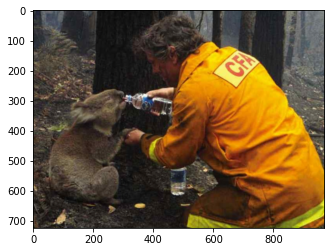

In [83]:
mosaic_image = read_image('hope.bmp')
soln_image = get_freeman_solution_image(mosaic_image, kernel_size=3)

plt.imshow(soln_image);

write_image('hope-recon-freeman.png', soln_image)

### Mosaicing an Image

Now lets take a step backwards and mosaic an image.

In [118]:
def get_mosaic_image(original_image):
    '''
    Generate the mosaic image using the Bayer Pattern.
    '''
    mosaic_image = np.zeros(original_image.shape[:2], dtype=original_image.dtype)
    
    # split colors into their own layer
    #        R   G_1
    #       G_2   B
    # R
    mosaic_image[::2, ::2] = original_image[::2, ::2, 0]
    # G1/2
    mosaic_image[::2, 1::2] = original_image[::2, 1::2, 1]
    mosaic_image[1::2, ::2] = original_image[1::2, ::2, 1] 
    # B
    mosaic_image[1::2, 1::2] = original_image[1::2, 1::2, 2] 

    return mosaic_image

Use `tony.jpg` to check my `get_mosaic_function`

In [85]:
original_image = read_image('tony.jpg')
mosaic_image = get_mosaic_image(original_image)
mosaic_image_gt = read_image('tony.bmp')

# create mosaic, should be the same as ground truth
avg_err, max_err = compute_errors(mosaic_image, mosaic_image_gt, show_err=False)
print(f'get_mosaic_function, avg_err={avg_err:.4f}, max_err={max_err:.4f}')


get_mosaic_function, avg_err=0.0000, max_err=0.0000


/home/andy/.conda/envs/ece549-mp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Use any 2 images you find interesting and generate their mosaics as well as their demosaics. Try to find images that break your demosaicing function.

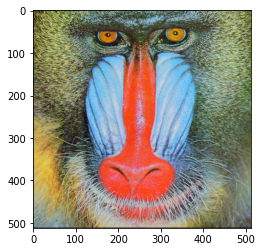

In [119]:
original_image = read_image('baboon.tiff')
mosaic_image = get_mosaic_image(original_image)

plt.imshow(original_image);

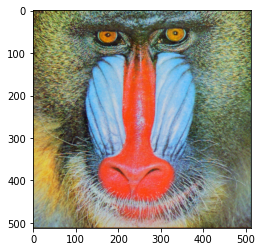

In [120]:
soln_image = get_freeman_solution_image(mosaic_image)
plt.imshow(soln_image);
write_image('baboon-recon-freeman.png', soln_image)

baboon, avg_err=258.5282, max_err=24964.0000


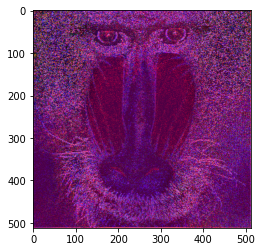

In [121]:
avg_err, max_err = compute_errors(soln_image, original_image, show_err=True)
print(f'baboon, avg_err={avg_err:.4f}, max_err={max_err:.4f}')

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('baboon-error-freeman.png', err)

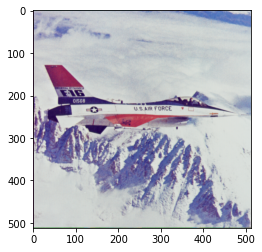

In [122]:
original_image = read_image('airplane.tiff')
mosaic_image = get_mosaic_image(original_image)

plt.imshow(original_image);

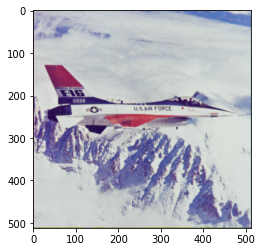

In [123]:
soln_image = get_freeman_solution_image(mosaic_image)
plt.imshow(soln_image);
write_image('airplane-recon-freeman.png', soln_image)

airplane, avg_err=52.9292, max_err=32400.0000


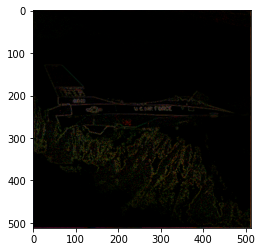

In [124]:
avg_err, max_err = compute_errors(soln_image, original_image, show_err=True)
print(f'airplane, avg_err={avg_err:.4f}, max_err={max_err:.4f}')

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('airplane-error-freeman.png', err)

### Bonus Points

In [125]:
def get_bonus_solution_image(mosaic_image, alpha=1/2, beta=5/8, gamma=3/4):
    # we have lots of non-integer operations later on
    split_image = split_mosaic_image(mosaic_image).astype(float)

    ### bilinear interpolation
    # RB share the same kernel
    rb_kernel = [
        [0.25, 0.5,  0.25],
        [0.5,    1,   0.5],
        [0.25, 0.5,  0.25]
    ]
    # G does not need diagonal components
    g_kernel = [
        [   0, 0.25,    0],
        [0.25,    1, 0.25], 
        [   0, 0.25,    0]
    ]
    
    # loop over each color and do bilinear interpolation    
    bi = split_image.copy()
    for i, kernel in enumerate((rb_kernel, g_kernel, rb_kernel)):
        bi[..., i] = conv2(bi[..., i], kernel)

    ### laplacian correction
    # we need laplacians first
    lap_kernel = [
        [    0, 0, -0.25, 0,     0],
        [    0, 0,     0, 0,     0],
        [-0.25, 0,     1, 0, -0.25],
        [    0, 0,     0, 0,     0],
        [    0, 0, -0.25, 0,     0]
    ]

    lap = split_image.copy()
    for i in range(3):
        lap[..., i] = conv2(lap[..., i], lap_kernel)

    #     R mask [ ::2,  ::2]
    #   G_1 mask [ ::2, 1::2]
    #   G_2 mask [1::2,  ::2]
    #     B mask [1::2, 1::2]

    # do the actual correction, start from bilinear
    soln_image = bi.copy()
    
    # 1) fix green
    #   G at R = G_bl + a*dR
    soln_image[::2, ::2, 1] = bi[::2, ::2, 1] + alpha*lap[::2, ::2, 0]
    #   G at B = G_bl + a*dB
    soln_image[1::2, 1::2, 1] = bi[1::2, 1::2, 1] + alpha*lap[1::2, 1::2, 2]
    
    # 2) fix red
    #   R at G1/2 = R_bl + b*dG1/2
    soln_image[::2, 1::2, 0] = bi[::2, 1::2, 0] + beta*lap[::2, 1::2, 1]
    soln_image[1::2, ::2, 0] = bi[1::2, ::2, 0] + beta*lap[1::2, ::2, 1]
    #   R at B = R_bl + b*dB
    soln_image[1::2, 1::2, 0] = bi[1::2, 1::2, 0] + beta*lap[1::2, 1::2, 2]
    
    # 3) fix blue
    #   B at G1/2 = B_bl + g*dG1/2
    soln_image[::2, 1::2, 2] = bi[::2, 1::2, 2] + gamma*lap[::2, 1::2, 1]
    soln_image[1::2, ::2, 2] = bi[1::2, ::2, 2] + gamma*lap[1::2, ::2, 1]
    #   B at R = B_bl + g*dR
    soln_image[::2, ::2, 2] = bi[::2, ::2, 2] + gamma*lap[::2, ::2, 0]

    # restore to ubyte
    soln_image = np.clip(soln_image, 0, 255)
    soln_image = soln_image.astype(np.uint8)

    return soln_image

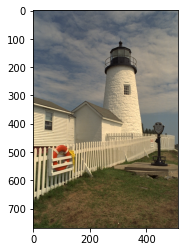

In [126]:
original_image = read_image('lighthouse.png')
mosaic_img = get_mosaic_image(original_image)

plt.imshow(original_image);

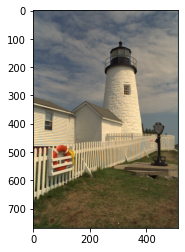

In [127]:
soln_image = get_solution_image(mosaic_img)
plt.imshow(soln_image);
write_image('lighthouse-recon-linear.png', soln_image)

lighthouse (linear), avg_err=107.0358, max_err=18225.0000


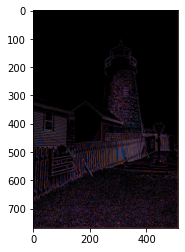

In [128]:
avg_err, max_err = compute_errors(soln_image, original_image, show_err=True)
print(f'lighthouse (linear), avg_err={avg_err:.4f}, max_err={max_err:.4f}')

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('lighthouse-error-linear.png', err)

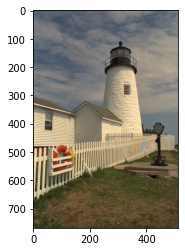

In [129]:
soln_image = get_freeman_solution_image(mosaic_img)
plt.imshow(soln_image);
write_image('lighthouse-recon-freeman.png', soln_image)

lighthouse (freeman), avg_err=67.5109, max_err=17689.0000


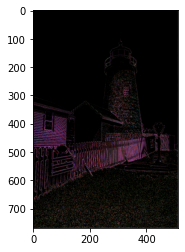

In [130]:
avg_err, max_err = compute_errors(soln_image, original_image, show_err=True)
print(f'lighthouse (freeman), avg_err={avg_err:.4f}, max_err={max_err:.4f}')

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('lighthouse-error-freeman.png', err)

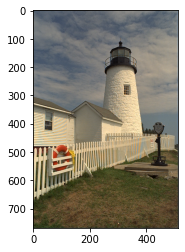

In [131]:
soln_image = get_bonus_solution_image(mosaic_img)
plt.imshow(soln_image);
write_image('lighthouse-recon-bonus.png', soln_image)

lighthouse (bonus), avg_err=49.8144, max_err=7744.0000


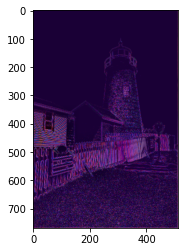

In [132]:
avg_err, max_err = compute_errors(soln_image, original_image, show_err=True)
print(f'lighthouse (bonus), avg_err={avg_err:.4f}, max_err={max_err:.4f}')

err = compute_errors(soln_image, original_image, show_err=False, return_map=True)
write_image('lighthouse-error-bonus.png', err)